## Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:

- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time t+1 to t+3) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder.
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition1. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

1Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [41]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from IPython.display import Image
from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
data_dir = './data'
# load the csv file
energy = pd.read_csv(os.path.join(data_dir, 'energy.csv'), parse_dates=['timestamp'])
# make the timestamp the index
energy.index = energy['timestamp']
# split the timestamp as hour equaly sets
energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                                          max(energy['timestamp']),
                                          freq='H'))
# drop the timestamp column
energy = energy.drop('timestamp', axis=1)
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [3]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

T = 6
# Because we have forecasting 3 steps ahead
HORIZON = 3

### Select data for training set

In [4]:
train = energy.copy()[energy.index < valid_start_dt][['load', 'temp']]

Scale data to be in range (0, 1). **This transformation should be calibrated on the training set only.** 

This is to prevent information from the validation or test sets leaking into the training data.

In [5]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

# here we need to scale the two input features
X_scaler = MinMaxScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)

Use the **TimeSeriesTensor** convenience class to:

- Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
- Discard any samples with missing values
- Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [6]:
tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, {'X':(range(-T+1, 1), ['load', 'temp'])})

In [8]:
train_inputs.dataframe.head()

tensor              target              X                                     \
feature                  y           load                          temp        
time step              t+1  t+2  t+3  t-5  t-4  t-3  t-2  t-1    t  t-5  t-4   
2012-01-01 05:00:00   0.18 0.23 0.29 0.22 0.18 0.14 0.13 0.13 0.15 0.42 0.43   
2012-01-01 06:00:00   0.23 0.29 0.35 0.18 0.14 0.13 0.13 0.15 0.18 0.43 0.40   
2012-01-01 07:00:00   0.29 0.35 0.37 0.14 0.13 0.13 0.15 0.18 0.23 0.40 0.41   
2012-01-01 08:00:00   0.35 0.37 0.37 0.13 0.13 0.15 0.18 0.23 0.29 0.41 0.42   
2012-01-01 09:00:00   0.37 0.37 0.37 0.13 0.15 0.18 0.23 0.29 0.35 0.42 0.41   

tensor                                   
feature                                  
time step            t-3  t-2  t-1    t  
2012-01-01 05:00:00 0.40 0.41 0.42 0.41  
2012-01-01 06:00:00 0.41 0.42 0.41 0.40  
2012-01-01 07:00:00 0.42 0.41 0.40 0.39  
2012-01-01 08:00:00 0.41 0.40 0.39 0.39  
2012-01-01 09:00:00 0.40 0.39 0.39 0.43

### Validation set 

Keeping T hours from the training set in order to construct initial features

In [9]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load', 'temp']]
valid[['load', 'temp']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

### RNN Forecasting

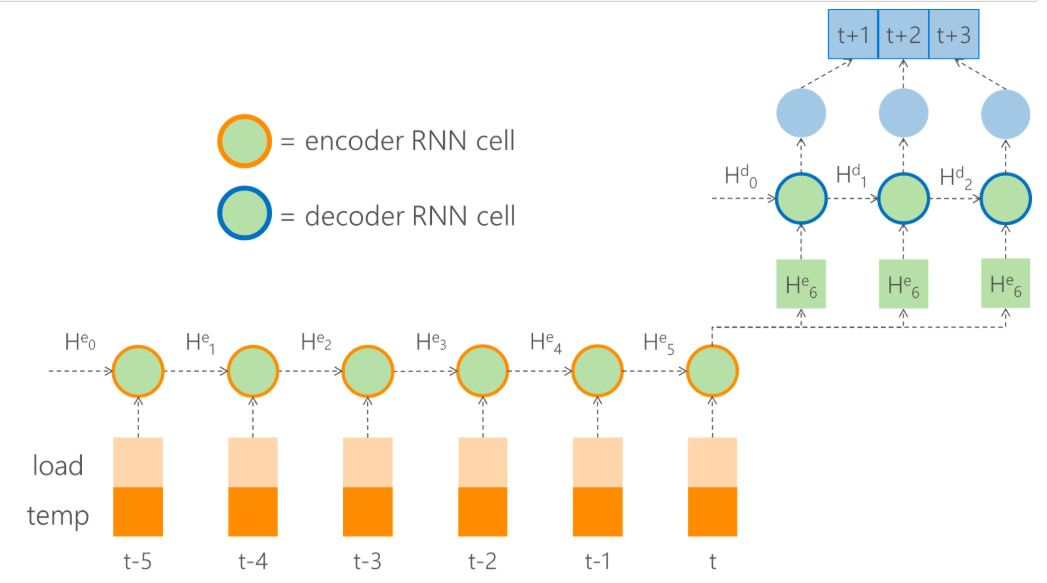

In [42]:
Image("images/simple_encoder_decoder.JPG")

In [10]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [11]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 10

In [12]:
model = Sequential()

model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(RepeatVector(HORIZON))
model.add(GRU(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))

model.add(Flatten())

W0229 22:05:09.737202 68112 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0229 22:05:09.758197 68112 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0229 22:05:09.762265 68112 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [13]:
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

W0229 22:05:26.574229 68112 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 120       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 5)              0         
_________________________________________________________________
gru_2 (GRU)                  (None, 3, 5)              165       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 1)              6         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                 0         
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [14]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [15]:
model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop],
          verbose=1)

W0229 22:07:07.683865 68112 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0229 22:07:07.690833 68112 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 23368 samples, validate on 1461 samples
Epoch 1/10
23368/23368 [==============================] - 5s 201us/step - loss: 0.0190 - val_loss: 0.0060
Epoch 2/10
23368/23368 [==============================] - 4s 158us/step - loss: 0.0057 - val_loss: 0.0055
Epoch 3/10
23368/23368 [==============================] - 3s 139us/step - loss: 0.0046 - val_loss: 0.0052
Epoch 4/10
23368/23368 [==============================] - 3s 127us/step - loss: 0.0039 - val_loss: 0.0038
Epoch 5/10
23368/23368 [==============================] - 3s 137us/step - loss: 0.0037 - val_loss: 0.0031
Epoch 6/10
23368/23368 [==============================] - 3s 139us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/10
23368/23368 [==============================] - 3s 147us/step - loss: 0.0036 - val_loss: 0.0029
Epoch 8/10
23368/23368 [==============================] - 3s 130us/step - loss: 0.0035 - val_loss: 0.0046
Epoch 9/10
23368/23368 [==============================] - 3s 147us/step - loss: 0.0035 - val_loss: 0.00

## Evaluate Model

In [16]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

In [17]:
predictions = model.predict(test_inputs['X'])

In [18]:
predictions

array([[0.23, 0.3 , 0.37],
       [0.31, 0.38, 0.44],
       [0.39, 0.46, 0.51],
       ...,
       [0.62, 0.56, 0.5 ],
       [0.56, 0.49, 0.43],
       [0.52, 0.47, 0.42]], dtype=float32)

In [19]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,723.73","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,971.78","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,244.79","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,396.63","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,507.24","3,436.00"


In [20]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.02
t+2   0.04
t+3   0.06
Name: APE, dtype: float64

In [22]:
mape(eval_df['prediction'], eval_df['actual'])

0.04171224510859758

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (t+1) are more accurate than those for 2 or 3 steps ahead

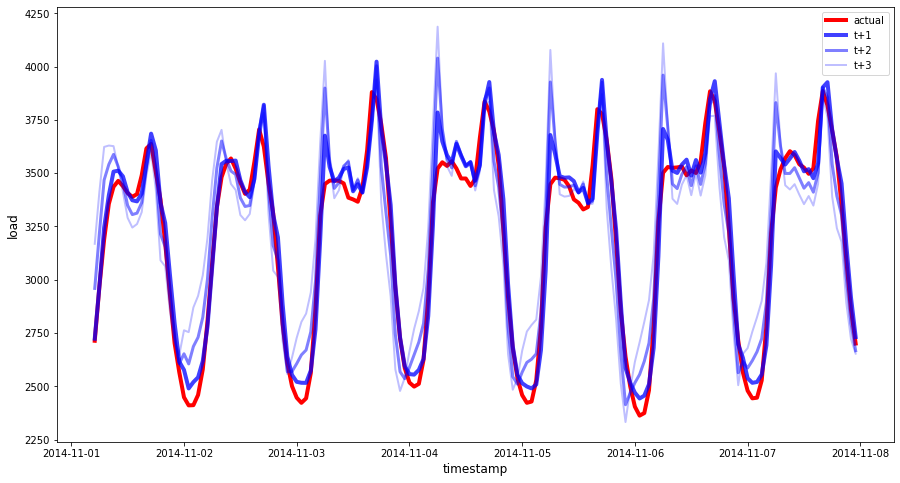

In [43]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0, label='actual')
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75, label='t+1')
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5, label='t+2')
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25, label='t+3')
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()